In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
crime_data = pd.read_csv('/content/drive/MyDrive/Crime_Data.csv')
crime_data.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


In [ ]:
crime_data.info()
crime_data.isnull().sum()
# Optional: Drop any columns with too many null values
crime_data = crime_data.dropna(subset=['DATE OCC', 'AREA NAME', 'Crm Cd Desc'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005062 entries, 0 to 1005061
Data columns (total 28 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   DR_NO           1005062 non-null  int64  
 1   Date Rptd       1005062 non-null  object 
 2   DATE OCC        1005062 non-null  object 
 3   TIME OCC        1005062 non-null  int64  
 4   AREA            1005062 non-null  int64  
 5   AREA NAME       1005062 non-null  object 
 6   Rpt Dist No     1005062 non-null  int64  
 7   Part 1-2        1005062 non-null  int64  
 8   Crm Cd          1005062 non-null  int64  
 9   Crm Cd Desc     1005062 non-null  object 
 10  Mocodes         853371 non-null   object 
 11  Vict Age        1005062 non-null  int64  
 12  Vict Sex        860345 non-null   object 
 13  Vict Descent    860333 non-null   object 
 14  Premis Cd       1005046 non-null  float64
 15  Premis Desc     1004474 non-null  object 
 16  Weapon Used Cd  327246 non-null   fl

In [ ]:
# Convert DATE OCC to datetime
crime_data['DATE OCC'] = pd.to_datetime(crime_data['DATE OCC'])
crime_data['Year'] = crime_data['DATE OCC'].dt.year
crime_data['Month'] = crime_data['DATE OCC'].dt.month
crime_data['Hour'] = (crime_data['TIME OCC'] // 100).astype(int)

/tmp/ipython-input-13-1540837937.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data['DATE OCC'] = pd.to_datetime(crime_data['DATE OCC'])


In [ ]:
# If XGBoost isn't installed:
# !pip install xgboost

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Create target column: 1 if the crime is related to a vehicle, else 0
vehicle_related_types = [
    "VEHICLE STOLEN",
    "BURGLARY FROM VEHICLE",
    "THEFT OF IDENTITY",
    "VEHICLE THEFT",
    "BURGLARY"
]

crime_data["is_vehicle_related"] = crime_data["Crm Cd Desc"].isin(vehicle_related_types).astype(int)

# Preview
crime_data[["Crm Cd Desc", "is_vehicle_related"]].head()

,Crm Cd Desc,is_vehicle_related
0,VEHICLE - STOLEN,0
1,BURGLARY FROM VEHICLE,1
2,BIKE - STOLEN,0
3,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0
4,VEHICLE - STOLEN,0


In [ ]:
# Features: Area, Hour, Month, Year
X = crime_data[["Year", "Month", "Hour", "AREA NAME"]].copy()

# Encode AREA NAME
X = pd.get_dummies(X, columns=["AREA NAME"], drop_first=True)

y = crime_data["is_vehicle_related"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
model = xgb.XGBClassifier(random_state=42, eval_metric="logloss")
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90    164227
           1       0.63      0.01      0.02     36786

    accuracy                           0.82    201013
   macro avg       0.73      0.50      0.46    201013
weighted avg       0.78      0.82      0.74    201013


Confusion Matrix:
 [[164025    202]
 [ 36439    347]]


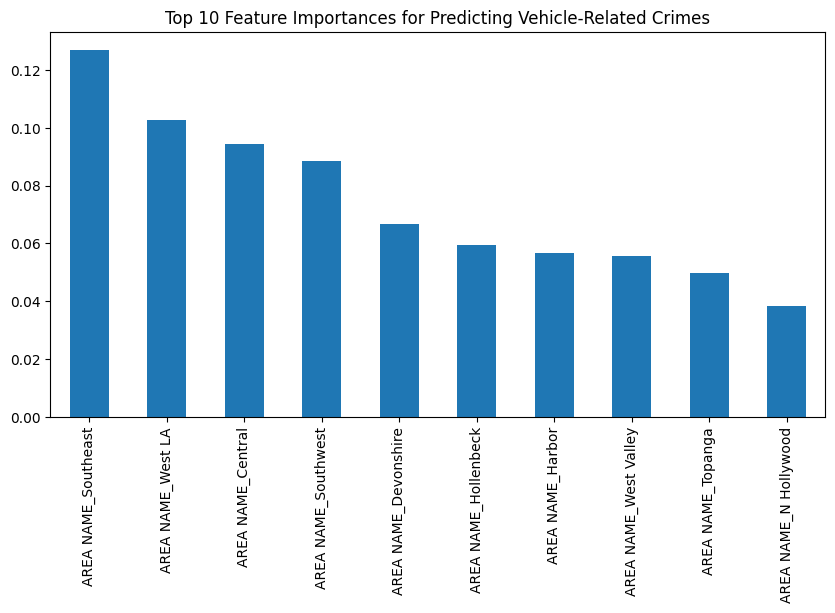

In [ ]:
importances = model.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10,5))
pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Feature Importances for Predicting Vehicle-Related Crimes")
plt.show()